In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from catboost import CatBoostClassifier
import pandas as pd
import json
from pandas import json_normalize
from tqdm import tqdm_notebook as tqdm
import numpy as np
import ast
import json

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../../'))

from core.train_utils import calculate_roi, get_winner_favorite, combine_df

pd.set_option('display.precision',6)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
with open('../../data/Catboost_v1_0/generated_features_08.04.2021.txt', 'r') as outfile:
    generated_features = json.load(outfile)
fighter1_stats = generated_features['fighter1_stats']
fighter2_stats = generated_features['fighter2_stats']
difference_cols = generated_features['difference_cols']

cat_cols = ['city', 'country', 'is_fight_night', 'weightCategory.id', 
              'f1_country', 'f2_country', 'f1_city', 'f2_city']

train_cols = cat_cols + fighter1_stats + fighter2_stats + difference_cols + ['f1_odds', 'f2_odds', 'odds_difference']# +  #['f1_odds', 'f2_odds', 'odds_difference'] +


In [4]:
df = pd.read_csv('../../data/Catboost_v1_0/events_joined_total_08.04.2021.csv', index_col=0)
df['eventDate.date'] = pd.to_datetime(df['eventDate.date'])
df['weightCategory.id'] = df['weightCategory.id'].astype('object')

print(df.shape)

df[cat_cols] = df[cat_cols].fillna('unknown')
df = df[(df['f1_count_of_fights'] >= 1) & (df['f2_count_of_fights'] >= 1)]

train1 = df[(df['eventDate.date'].dt.year > 2005) & (df['eventDate.date'].dt.year < 2020) &
           ((df['type']=='straight'))]

val1  = df[(df['eventDate.date'].dt.year >= 2020) & (df['eventDate.date'].dt.year < 2021) &
          ((df['type']=='straight'))]
val1 = val1.reset_index()
val1 = val1[~val1['odds_difference'].isna()]
# 'f1_timezone', 'f2_timezone', 'timezone', 'f1_name', 'f2_name', 


train2 = df[(df['eventDate.date'].dt.year > 2005) & (df['eventDate.date'].dt.year < 2020) &
           ((df['type']=='reversed'))]

val2  = df[(df['eventDate.date'].dt.year >= 2020) & (df['eventDate.date'].dt.year < 2021) &
          ((df['type']=='reversed'))]
val2 = val2.reset_index()
val2 = val2[~val2['odds_difference'].isna()]

print(train1.shape, val1.shape)
print(train2.shape, val2.shape)

(13754, 214)
(3976, 214) (331, 215)
(3976, 214) (331, 215)


In [27]:
# cat_features = np.where(train1[train_cols].dtypes == 'object')[0]

X_train = train1[train_cols].drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_train = train1['winner'].astype(int)

X_val = val1[train_cols].drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_val = val1['winner'].astype(int)

print(X_train.shape, X_val.shape)
clf1 = CatBoostClassifier(iterations=3000, 
                           depth=6,
                           learning_rate=0.001,
                           grow_policy='Depthwise', #SymmetricTree
                           border_count=255,
                           colsample_bylevel=0.4,
                           subsample=0.2,
#                            random_strength=100,
                           l2_leaf_reg=40,
                           eval_metric='Accuracy',
                           boosting_type='Plain', # 'Plain'
                           bootstrap_type='Bernoulli',# 'Bernoulli' Bayesian
                           max_ctr_complexity=5,
                           task_type='CPU',
                           cat_features=[0,1,2,3,4,5,6,7],
#                            cat_features=cat_features,
                          use_best_model=False,
                          )

clf1.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val), verbose=False)

clf1.save_model('../../models/Catboost_v1_0/catboost_v1_0_06.04.2021_1.cat')
clf1.get_feature_importance(prettified=True)#[:50]['Feature Id'].values

(3976, 191) (331, 191)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,age_difference,12.769565
1,f2_legSwing,4.303435
2,f1_legSwing,3.062313
3,f1_age,2.656817
4,f2_city,2.183256
...,...,...
186,cumsum_knockdowns_difference,0.000087
187,f2_cumsum_knockdowns,0.000041
188,knockdowns_PM_difference,0.000006
189,f1_cumsum_knockdowns,0.000000


In [6]:
# train_cols = clf1.get_feature_importance(prettified=True)[:50]['Feature Id'].values
# cat_features = np.where(train1[train_cols].dtypes == 'object')[0]
# cat_features

In [28]:
X_train = train2[train_cols].drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_train = train2['winner'].astype(int)

X_val = val2[train_cols].drop(['f1_odds', 'f2_odds', 'odds_difference'], axis=1)
y_val = val2['winner'].astype(int)

clf2 = CatBoostClassifier(iterations=3000, 
                           depth=6,
                           learning_rate=0.001,
                           grow_policy='Depthwise', #SymmetricTree
                           border_count=255,
                           colsample_bylevel=0.4,
                           subsample=0.2,
#                            random_strength=100,
                           l2_leaf_reg=40,
                           eval_metric='Accuracy',
                           boosting_type='Plain', # 'Plain'
                           bootstrap_type='Bernoulli',# 'Bernoulli' Bayesian
                           max_ctr_complexity=5,
                           task_type='CPU',
                           cat_features=[0,1,2,3,4,5,6,7],
#                            cat_features=cat_features,
                          use_best_model=False,
                          )



clf2.fit(X_train, y_train, plot=True, eval_set=(X_val, y_val), verbose=False)

clf2.save_model('../../models/Catboost_v1_0/catboost_v1_0_06.04.2021_2.cat')
clf2.get_feature_importance(prettified=True)#[:50]['Feature Id'].values

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,age_difference,11.807633
1,f1_legSwing,4.387573
2,f2_legSwing,3.104744
3,f2_age,2.786842
4,f1_city,2.168049
...,...,...
186,cumsum_knockdowns_difference,0.000057
187,f1_cumsum_knockdowns,0.000044
188,f1_knockdowns_PM,0.000041
189,f2_cumsum_knockdowns,0.000000


In [29]:
clf2.get_feature_importance(prettified=True)['Feature Id'].values

array(['age_difference', 'f1_legSwing', 'f2_legSwing', 'f2_age',
       'f1_city', 'takedown_PM_difference', 'win_streak_difference',
       'f2_takedown_PM', 'f2_city', 'f1_age',
       'hitsHead_accuracy_difference', 'f2_hitsHead_accuracy',
       'protectionPassage_PM_difference',
       'accentedHitsPositionParter_PM_difference', 'armSpan_difference',
       'accentedHits_PM_difference', 'legSwing_difference', 'f2_country',
       'hitsHead_PM_difference', 'f2_protectionPassage_PM',
       'KO_percent_difference', 'f2_accentedHitsPositionParter_PM',
       'cumsum_takedownSuccessful_difference', 'f2_KO_percent',
       'f2_takedown_accuracy', 'f1_hitsHead_PM', 'f1_KO_percent',
       'f2_accentedHits_accuracy', 'city',
       'f2_accentedHitsPositionDistance_accuracy', 'f2_hitsHead_PM',
       'cumsum_protectionPassage_difference', 'DEC_percent_difference',
       'weightCategory.id', 'cumsum_winner_difference',
       'f1_protectionPassage_PM', 'f1_cumsum_hitsHeadTotal', 'f2_hits_

In [30]:
print('Точность букмейкера')
val1['bookmaker_bet'] = (val1['f1_odds'] < val1['f2_odds']).astype(int)
(val1['bookmaker_bet'] == val1['winner']).mean()

Точность букмейкера


0.649546827794562

In [31]:
y_proba = clf1.predict_proba(val1[clf1.feature_names_])
val1['y_proba'] = y_proba[:,1]
val1['y_pred'] = val1['y_proba'] > 0.5

y_proba = clf2.predict_proba(val2[clf2.feature_names_])
val2['y_proba'] = y_proba[:,1]
val2['y_pred'] = val2['y_proba'] > 0.5

val1['y_proba_comb'] = (val1['y_proba'] + 1-val2['y_proba']) / 2
val1['y_pred_comb'] = val1['y_proba_comb'] > 0.5

(val1['y_pred'] != val2['y_pred']).mean()

0.9214501510574018

In [32]:
calculate_roi(val1, pred_col='y_pred')
calculate_roi(val2, pred_col='y_pred')
calculate_roi(val1, pred_col='y_pred_comb')

  0%|          | 0/331 [00:00<?, ?it/s]

{'accuracy:': 0.622356495468278,
 'bets_count:': 331,
 'finish_bank:': 2686.0,
 'roi:': 8.114803625377643}


  0%|          | 0/331 [00:00<?, ?it/s]

{'accuracy:': 0.6283987915407855,
 'bets_count:': 331,
 'finish_bank:': 2928.0,
 'roi:': 8.845921450151057}


  0%|          | 0/331 [00:00<?, ?it/s]

{'accuracy:': 0.6404833836858006,
 'bets_count:': 331,
 'finish_bank:': 3358.0,
 'roi:': 10.145015105740182}


In [33]:
same_preds = val1[val1['y_pred'] != val2['y_pred']]
calculate_roi(same_preds)

  0%|          | 0/305 [00:00<?, ?it/s]

{'accuracy:': 0.6360655737704918,
 'bets_count:': 305,
 'finish_bank:': 3201.0,
 'roi:': 10.495081967213114}


In [34]:
val1 = get_winner_favorite(val1)
val2 = get_winner_favorite(val2)

bet_on_favorite = val1[val1['y_pred'] == val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val2[val2['y_pred'] == val2['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val1[val1['y_pred_comb'] == val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred_comb')

  0%|          | 0/204 [00:00<?, ?it/s]

{'accuracy:': 0.7205882352941176,
 'bets_count:': 204,
 'finish_bank:': 1253.0,
 'roi:': 6.142156862745098}


  0%|          | 0/213 [00:00<?, ?it/s]

{'accuracy:': 0.7183098591549296,
 'bets_count:': 213,
 'finish_bank:': 1367.0,
 'roi:': 6.417840375586854}


  0%|          | 0/214 [00:00<?, ?it/s]

{'accuracy:': 0.7242990654205608,
 'bets_count:': 214,
 'finish_bank:': 1423.0,
 'roi:': 6.649532710280374}


In [35]:
val1 = get_winner_favorite(val1)
# val2 = get_winner_favorite(val2)

bet_on_favorite = val1[val1['y_pred'] != val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val2[val2['y_pred'] != val2['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred')
bet_on_favorite = val1[val1['y_pred_comb'] != val1['favorite']]
calculate_roi(bet_on_favorite, pred_col='y_pred_comb')

  0%|          | 0/127 [00:00<?, ?it/s]

{'accuracy:': 0.4645669291338583,
 'bets_count:': 127,
 'finish_bank:': 1433.0,
 'roi:': 11.283464566929133}


  0%|          | 0/118 [00:00<?, ?it/s]

{'accuracy:': 0.4661016949152542,
 'bets_count:': 118,
 'finish_bank:': 1561.0,
 'roi:': 13.228813559322035}


  0%|          | 0/117 [00:00<?, ?it/s]

{'accuracy:': 0.48717948717948717,
 'bets_count:': 117,
 'finish_bank:': 1935.0,
 'roi:': 16.53846153846154}


In [36]:
val1[:1]

,index,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPosi

In [37]:
val2[:1]

,index,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPosi

In [74]:
1-0.483331

0.516669

In [55]:
w = val1[:1][clf1.feature_names_]

In [56]:
0.5175894306818433, 0.5166692929810301

0    [Las Vegas, USA, False, 14, Ireland, USA, Dubl...
dtype: object

In [57]:
(w.values == q.values)#.mean().mean()

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [65]:
w.values[0]

array(['Las Vegas', 'USA', False, 14, 'Ireland', 'USA', 'Dublin',
       'Denver', 2061.0, 9, 423.0, 260.0, 6.0, 4.0, 0.0, 0.0, 350.0,
       189.0, 0.0, 6.0, 299.0, 156.0, 38.0, 24.0, 13.0, 9.0, 273.0, 135.0,
       16.0, 13.0, 61.0, 41.0, 2, 0, 7, 2, 0.6146572104018913,
       0.6666666666666666, 0.54, 0.5217391304347826, 0.631578947368421,
       0.6923076923076923, 0.4945054945054945, 0.8125, 0.6721311475409836,
       0.2222222222222222, 0.0, 0.7777777777777778, 0.2222222222222222,
       7.5691411935953425, 0.1164483260553129, 5.502183406113537,
       4.541484716157205, 0.6986899563318778, 0.2620087336244541,
       3.930131004366812, 0.3784570596797671, 1.1935953420669578, 0.0,
       0.1746724890829694, 0, 1, 31.0, 175.26, 187.96, 101.6, 0, 0, 0,
       7959.0, 25, 1552.0, 798.0, 32.0, 11.0, 10.0, 1.0, 1460.0, 718.0,
       0.0, 14.0, 1040.0, 393.0, 228.0, 159.0, 192.0, 166.0, 1245.0,
       571.0, 103.0, 65.0, 112.0, 82.0, 12, 0, 16, 7, 0.5141752577319587,
       0.34375, 0.4

In [61]:
q.values[0]

['Las Vegas',
 'USA',
 False,
 '14',
 'Ireland',
 'USA',
 'Dublin',
 'Denver',
 2061.0,
 9,
 423.0,
 260.0,
 6.0,
 4.0,
 0.0,
 0.0,
 350.0,
 189.0,
 0.0,
 6.0,
 299.0,
 156.0,
 38.0,
 24.0,
 13.0,
 9.0,
 273.0,
 135.0,
 16.0,
 13.0,
 61.0,
 41.0,
 2,
 0,
 7,
 2,
 0.6146572104018913,
 0.6666666666666666,
 0.54,
 0.5217391304347826,
 0.631578947368421,
 0.6923076923076923,
 0.4945054945054945,
 0.8125,
 0.6721311475409836,
 0.2222222222222222,
 0.0,
 0.7777777777777778,
 0.2222222222222222,
 7.5691411935953425,
 0.1164483260553129,
 5.502183406113537,
 4.541484716157205,
 0.6986899563318778,
 0.2620087336244541,
 3.930131004366812,
 0.3784570596797671,
 1.1935953420669578,
 0.0,
 0.1746724890829694,
 0,
 1,
 31.0,
 175.26,
 187.96,
 101.6,
 0,
 0,
 0,
 7959.0,
 25,
 1552.0,
 798.0,
 32.0,
 11.0,
 10.0,
 1.0,
 1460.0,
 718.0,
 0.0,
 14.0,
 1040.0,
 393.0,
 228.0,
 159.0,
 192.0,
 166.0,
 1245.0,
 571.0,
 103.0,
 65.0,
 112.0,
 82.0,
 12,
 0,
 16,
 7,
 0.5141752577319587,
 0.34375,
 0.4917

In [66]:
['Las Vegas', 'USA', False, '14', 'USA', 'Ireland', 'Denver', 'Dublin', 7959.0, 25, 1552.0, 798.0, 32.0, 11.0, 10.0, 1.0, 1460.0, 718.0, 0.0, 14.0, 1040.0, 393.0, 228.0, 159.0, 192.0, 166.0, 1245.0, 571.0, 103.0, 65.0, 112.0, 82.0, 12, 0, 16, 7, 0.5141752577319587, 0.34375, 0.4917808219178082, 0.3778846153846154, 0.6973684210526315, 0.8645833333333334, 0.4586345381526104, 0.6310679611650486, 0.7321428571428571, 0.48, 0.0, 0.64, 0.28, 6.015831134564643, 0.0829249905767056, 5.4127402940067855, 2.9626837542404827, 1.198643045608745, 1.2514134941575576, 4.304560874481719, 0.4900113079532605, 0.6181681115718055, 0.0, 0.1055408970976253, 0, 2, 36.0, 185.42, 185.42, 102.87, 0, 1, 0, 2061.0, 9, 423.0, 260.0, 6.0, 4.0, 0.0, 0.0, 350.0, 189.0, 0.0, 6.0, 299.0, 156.0, 38.0, 24.0, 13.0, 9.0, 273.0, 135.0, 16.0, 13.0, 61.0, 41.0, 2, 0, 7, 2, 0.6146572104018913, 0.6666666666666666, 0.54, 0.5217391304347826, 0.631578947368421, 0.6923076923076923, 0.4945054945054945, 0.8125, 0.6721311475409836, 0.2222222222222222, 0.0, 0.7777777777777778, 0.2222222222222222, 7.5691411935953425, 0.1164483260553129, 5.502183406113537, 4.541484716157205, 0.6986899563318778, 0.2620087336244541, 3.930131004366812, 0.3784570596797671, 1.1935953420669578, 0.0, 0.1746724890829694, 0, 1, 31.0, 175.26, 187.96, 101.6, 0, 0, 0, -5898.0, -16.0, -1129.0, -538.0, -26.0, -7.0, -10.0, -1.0, -1110.0, -529.0, 0.0, -8.0, -741.0, -237.0, -190.0, -135.0, -179.0, -157.0, -972.0, -436.0, -87.0, -52.0, -51.0, -41.0, -10.0, 0.0, -9.0, -5.0, 0.10048195266993254, 0.32291666666666663, 0.04821917808219184, 0.14385451505016722, -0.06578947368421051, -0.17227564102564108, 0.03587095635288412, 0.1814320388349514, -0.06001170960187352, -0.2577777777777778, 0.0, 0.13777777777777778, -0.05777777777777782, 1.5533100590306992, 0.033523335478607294, 0.0894431121067516, 1.5788009619167225, -0.4999530892768671, -0.9894047605331036, -0.37442987011490736, -0.11155424827349336, 0.5754272304951523, 0.0, 0.06913159198534409, 0.0, -1.0, -5.0, -10.159999999999997, 2.5400000000000205, -1.2700000000000102, 0.0, -1.0, 0.0]

In [72]:
w = val2[:1][clf2.feature_names_]
w

,city,country,is_fight_night,weightCategory.id,f1_country,f2_country,f1_city,f2_city,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_age,f1_height,f1_armSpan,f1_legSwing,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_age,f2_height,f2_armSpan,f2_legSwing,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionClinchTotal_difference,cumsum_accentedHitsPositionClinchSuccessful_difference,cumsum_accentedHitsPositionParterTotal_difference,cumsum_accentedHitsPositionParterSuccessful_difference,cumsum_winMethods_[DEC]_difference

In [73]:
w = val1[:1][clf1.feature_names_]
w

,city,country,is_fight_night,weightCategory.id,f1_country,f2_country,f1_city,f2_city,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_age,f1_height,f1_armSpan,f1_legSwing,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_age,f2_height,f2_armSpan,f2_legSwing,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionClinchTotal_difference,cumsum_accentedHitsPositionClinchSuccessful_difference,cumsum_accentedHitsPositionParterTotal_difference,cumsum_accentedHitsPositionParterSuccessful_difference,cumsum_winMethods_[DEC]_difference

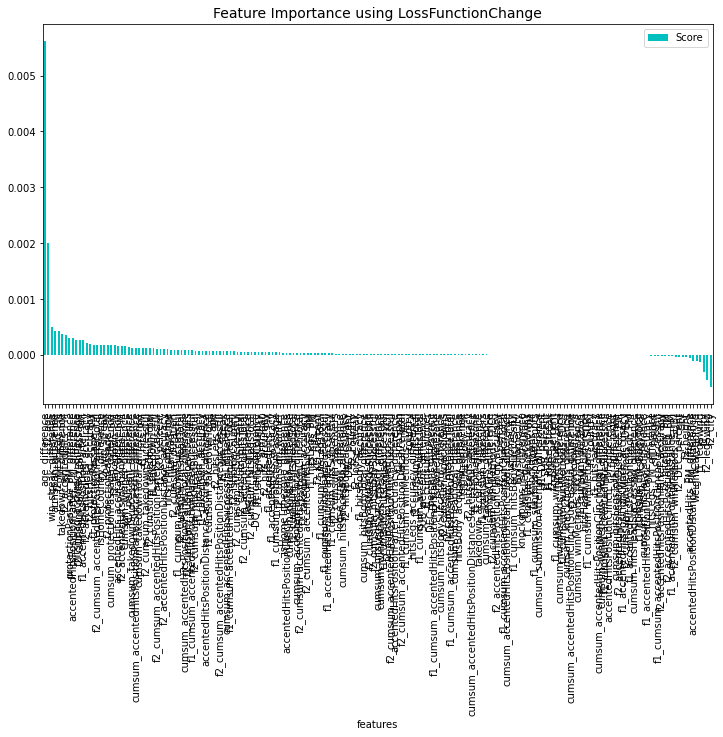

In [318]:
from catboost import Pool
import matplotlib.pyplot as plt

fi = clf1.get_feature_importance(Pool(X_val, label=y_val, cat_features=[0,1,2,3,4,5,6,7]),
                                type='LossFunctionChange')

feature_score1 = pd.DataFrame(list(zip(X_val.dtypes.index, fi)),
                                columns=['Feature','Score'])

feature_score1 = feature_score1.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score1.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('LossFunctionChange'), fontsize = 14)
ax.set_xlabel("features")
plt.show()

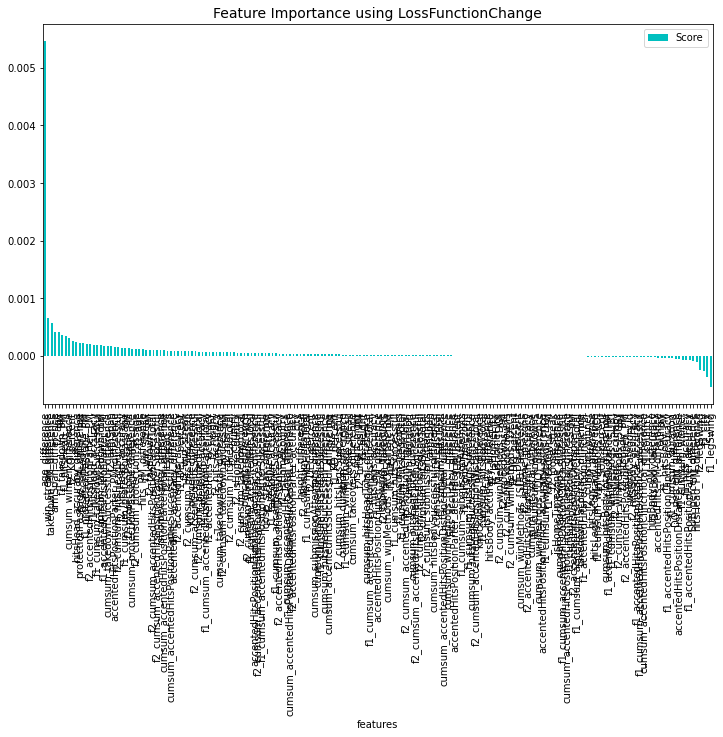

In [319]:
fi = clf2.get_feature_importance(Pool(X_val, label=y_val, cat_features=[0,1,2,3,4,5,6,7]),
                                type='LossFunctionChange')

feature_score2 = pd.DataFrame(list(zip(X_val.dtypes.index, fi)),
                                columns=['Feature','Score'])

feature_score2 = feature_score2.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score2.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('LossFunctionChange'), fontsize = 14)
ax.set_xlabel("features")
plt.show()

In [320]:
features1 = feature_score1[feature_score1['Score'] >= 0]
features2 = feature_score2[feature_score2['Score'] >= 0]
features1

,Feature,Score
184,age_difference,5.623869e-03
123,f2_age,2.010467e-03
182,win_streak_difference,4.953633e-04
186,armSpan_difference,4.260775e-04
113,f2_hitsHead_PM,4.200566e-04
...,...,...
66,f1_isHomeCity,7.904856e-07
180,knockdowns_PM_difference,4.047717e-07
41,f1_hitsLegs_accuracy,3.747258e-07
18,f1_cumsum_knockdowns,0.000000e+00


In [321]:
train_cols = set(features1['Feature']) & set(features2['Feature'])
train_cols = features1['Feature']#.drop('odds_difference', axis=1)
train_cols.tolist()

['age_difference',
 'f2_age',
 'win_streak_difference',
 'armSpan_difference',
 'f2_hitsHead_PM',
 'takedown_PM_difference',
 'f2_accentedHits_PM',
 'protectionPassage_PM_difference',
 'accentedHitsPositionParter_PM_difference',
 'hitsHead_accuracy_difference',
 'f2_cumsum_protectionPassage',
 'f1_accentedHitsPositionParter_PM',
 'f2_accentedHits_accuracy',
 'f2_hitsHead_accuracy',
 'f1_protectionPassage_PM',
 'f2_cumsum_accentedHitsPositionParterTotal',
 'isHomeCountry_difference',
 'f2_win_streak',
 'f2_protectionPassage_PM',
 'cumsum_protectionPassage_difference',
 'f2_takedown_PM',
 'accentedHits_accuracy_difference',
 'f2_accentedHitsPositionParter_PM',
 'cumsum_winner_difference',
 'KO_percent_difference',
 'cumsum_takedownSuccessful_difference',
 'cumsum_accentedHitsPositionParterSuccessful_difference',
 'cumsum_takedownTotal_difference',
 'f1_hits_PM',
 'f2_cumsum_takedownSuccessful',
 'f2_cumsum_takedownTotal',
 'f1_takedown_PM',
 'f2_cumsum_accentedHitsPositionParterSuccessfu

In [322]:
features1[['Feature']]

,Feature
184,age_difference
123,f2_age
182,win_streak_difference
186,armSpan_difference
113,f2_hitsHead_PM
...,...
66,f1_isHomeCity
180,knockdowns_PM_difference
41,f1_hitsLegs_accuracy
18,f1_cumsum_knockdowns
